In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV


=== Decision Tree ===
CV R² Mean: 0.4998
Test RMSE : 3013.44
Test MAE  : 1333.33
Test R²   : 0.7870


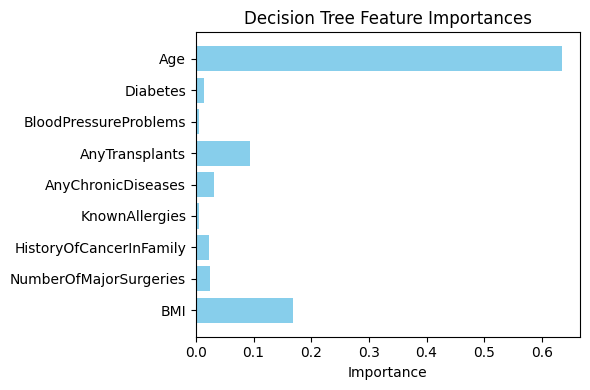


=== Random Forest ===
CV R² Mean: 0.7208
Test RMSE : 2421.43
Test MAE  : 1439.49
Test R²   : 0.8625


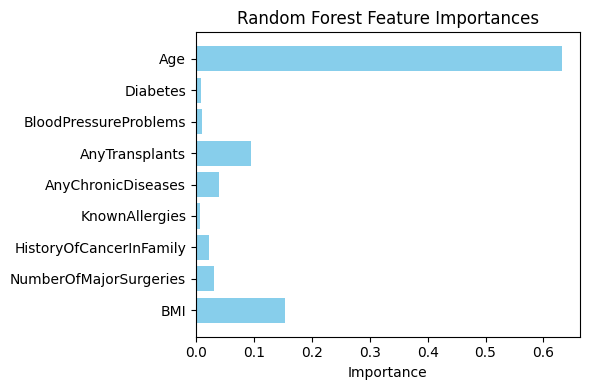


=== Gradient Boost ===
CV R² Mean: 0.7351
Test RMSE : 2487.11
Test MAE  : 1675.10
Test R²   : 0.8549


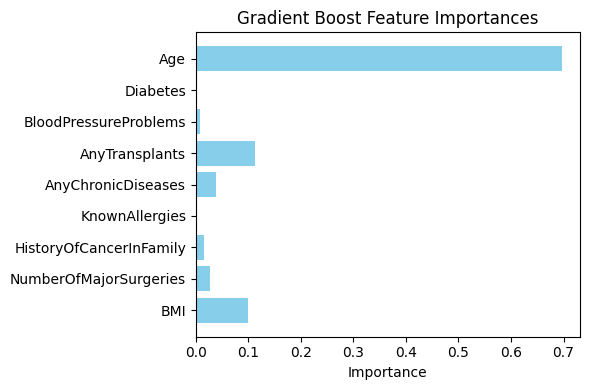

In [ ]:
# Load & preprocess data
df = pd.read_csv(r'insurance.csv')
df['Height_m'] = df['Height'] / 100
df['BMI']      = df['Weight'] / (df['Height_m'] ** 2)
df.drop(columns=['Height', 'Weight', 'Height_m'], inplace=True)

X = df.drop(columns=['PremiumPrice'])
y = df['PremiumPrice']

# Scale numeric features
num_cols = ['Age', 'BMI', 'NumberOfMajorSurgeries']
scaler   = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define tree-based models
models = {
    'Decision Tree'  : DecisionTreeRegressor(random_state=42),
    'Random Forest'  : RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boost' : GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Evaluate each model
results = {}
for name, model in models.items():
    # 5a. Cross-validation (R²)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    
    # 5b. Train & predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # 5c. Compute metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    
    # 5d. Feature importances
    importances = model.feature_importances_
    
    results[name] = {
        'CV R2 Mean': cv_scores.mean(),
        'Test RMSE' : rmse,
        'Test MAE'  : mae,
        'Test R2'   : r2,
        'Importances': importances
    }

# Display results
for name, res in results.items():
    print(f"\n=== {name} ===")
    print(f"CV R² Mean: {res['CV R2 Mean']:.4f}")
    print(f"Test RMSE : {res['Test RMSE']:.2f}")
    print(f"Test MAE  : {res['Test MAE']:.2f}")
    print(f"Test R²   : {res['Test R2']:.4f}")
    
    # Plot feature importances
    plt.figure(figsize=(6,4))
    plt.barh(X.columns, res['Importances'], color='skyblue')
    plt.title(f"{name} Feature Importances")
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


**Random Forest** is the best overall choice here:

* It achieves the **highest test R² (0.8625)**—so it explains the most variance on unseen data.
* It has the **lowest RMSE (₹2,421)**, meaning its predictions are, on average, closest to the true premiums.
* Its cross-validated R² (0.7208) is very close to the Gradient Boost’s (0.7351), but the RF model generalizes better at test time.

By contrast:

* **Decision Tree** is weakest (CV R² ≈ 0.50, test R² ≈ 0.79, RMSE ≈ ₹3,013).
* **Gradient Boosting** has a slightly higher CV R² (0.735) but under-performs RF on the test set (test R² = 0.8549, RMSE ≈ ₹2,487).

So for a balance of stability (CV) and real-world accuracy (test), Random Forest is your top performer.


Hyperparameter tuning 

In [ ]:
# Define Decision Tree and parameter grid
dt = DecisionTreeRegressor(random_state=42)
param_grid = {
    'max_depth'         : [None, 3, 5, 7, 10],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf'  : [1, 2, 4],
    'max_features'      : [None, 'sqrt', 'log2']
}

# Grid search with 5-fold CV optimizing R²
grid = GridSearchCV(
    dt, 
    param_grid, 
    cv=5, 
    scoring='r2', 
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best Decision Tree params:", grid.best_params_)
print("Best CV R²:", grid.best_score_)

# Evaluate the tuned tree on the test set
best_dt = grid.best_estimator_
y_pred_dt = best_dt.predict(X_test)

rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
mae_dt  = mean_absolute_error(y_test, y_pred_dt)
r2_dt   = r2_score(y_test, y_pred_dt)

print("\nTuned Decision Tree Performance on Test Set:")
print(f"  RMSE: {rmse_dt:.2f}")
print(f"  MAE : {mae_dt:.2f}")
print(f"  R²  : {r2_dt:.4f}")

# Save the scaler and tuned model
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(best_dt, 'tuned_decision_tree.joblib')

print("\nScaler and tuned Decision Tree model have been saved to disk.")

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best Decision Tree params: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best CV R²: 0.6682065594524091

Tuned Decision Tree Performance on Test Set:
  RMSE: 2755.08
  MAE : 1757.30
  R²  : 0.8220

Scaler and tuned Decision Tree model have been saved to disk.


Here’s how your **tuned Decision Tree** stacks up against the **linear baseline** and the **untuned tree models**:

| Model                              | RMSE (₹) | MAE (₹) | R²     | CV R² |
| ---------------------------------- | -------- | ------- | ------ | ----- |
| **Linear Regression (original y)** | 3,494.4  | 2,586.2 | 0.7136 | 0.617 |
| **Decision Tree (default)**        | 3,013.4  | 1,333.3 | 0.7870 | 0.500 |
| **Decision Tree (tuned)**          | 2,755.1  | 1,757.3 | 0.8220 | 0.668 |
| **Random Forest (untuned)**        | 2,421.4  | 1,439.5 | 0.8625 | 0.721 |
| **Gradient Boosting (untuned)**    | 2,487.1  | 1,675.1 | 0.8549 | 0.735 |

### 🔍 Key Takeaways

1. **Baseline Linear Regression**

   * RMSE ≈ ₹3.5 K, MAE ≈ ₹2.6 K, R² ≈ 0.71
   * Solid interpretability but relatively high error.

2. **Default Decision Tree**

   * Improved over linear: RMSE down to \~₹3.0 K, R² up to 0.79, MAE \~₹1.3 K—but severely overfits (CV R² \~0.50 vs test R² \~0.79).

3. **Tuned Decision Tree**

   * RMSE drops further to \~₹2.75 K and test R² climbs to \~0.82.
   * CV R² improves to \~0.67, meaning you’ve reduced overfitting.
   * **Trade-off:** MAE rose to ₹1.76 K (versus default’s ₹1.33 K), suggesting the tree now makes fewer large errors (lower RMSE) but more consistent mid-range errors (higher MAE).

4. **Random Forest & Gradient Boosting**

   * Still outperform even the tuned tree:

     * **RF:** RMSE \~₹2.42 K, R² \~0.86, CV R² \~0.72
     * **GBM:** RMSE \~₹2.49 K, R² \~0.85, CV R² \~0.74

---

### 🚀 Recommendations

* **Random Forest** remains the best off-the-shelf choice. Its ensemble nature better balances bias/variance.
* **Tuned Decision Tree** is a good simpler alternative if you need a single-tree model (easier to visualize), but expect slightly lower overall accuracy and higher MAE.
* Next, you might **hyper‐tune Random Forest and GBM** (e.g., via grid or randomized search) to squeeze out further gains, or deploy **the tuned DT for explainable underwriting** alongside the RF for pricing.